In [14]:
import pandas as pd
import geopandas as gpd
print(f"Pandas version: {pd.__version__}")

Pandas version: 2.2.2


In [17]:
df = pd.read_csv(r"C:\Users\HP\Downloads\sample_data.csv")
print(df.head())

        mmsi               timestamp       lat        lon
0  565761000  2023-03-15 00:27:44+00   1.26878  103.75827
1  538008084  2023-03-19 23:30:00+00  43.55962   10.29404
2  564654000  2023-03-12 08:22:53+00   1.23725  103.89135
3  529123000  2023-03-05 16:47:42+00  29.44367   48.93066
4  564780000  2023-03-11 06:35:20+00   1.27755  103.61026


In [43]:
import numpy as np

# Define the Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c


lat1, lon1 = 52.2296756, 21.0122287  
lat2, lon2 = 41.8919300, 12.5113300 

# Call the function with these values
distance = haversine(lat1, lon1, lat2, lon2)

# Print the result
print(f"Distance between Warsaw and Rome: {distance:.2f} km")



Distance between Warsaw and Rome: 1315.51 km


In [28]:
def calculate_distances(df):
    lats = np.radians(df['latitude'].values)
    lons = np.radians(df['longitude'].values)
    num_vessels = len(df)
    distances = np.zeros((num_vessels, num_vessels))

    for i in range(num_vessels):
        for j in range(i + 1, num_vessels):
            distance = haversine(lats[i], lons[i], lats[j], lons[j])
            distances[i, j] = distance
            distances[j, i] = distance  # Distance matrix is symmetric

    return distances

# Calculate distances
distances = calculate_distances(df)
print("Distances matrix:\n", distances)


Distances matrix:
 [[0.         5.19798721 0.12876539 0.07625802]
 [5.19798721 0.         5.18105581 5.17271785]
 [0.12876539 5.18105581 0.         0.19933502]
 [0.07625802 5.17271785 0.19933502 0.        ]]


In [29]:
def find_proximity_pairs(distances, threshold):
    # Get the indices of pairs with distances below the threshold
    proximity_pairs = np.where(distances < threshold)
    
    # Convert to list of tuples (i, j)
    pairs = list(zip(proximity_pairs[0], proximity_pairs[1]))
    
    # Remove self-pairs (i.e., pairs where i == j)
    pairs = [pair for pair in pairs if pair[0] != pair[1]]
    
    return pairs

# Define threshold distance
threshold_distance = 10.0  # Example threshold distance in kilometers

# Find proximity pairs
proximity_pairs = find_proximity_pairs(distances, threshold_distance)
print("Proximity pairs:\n", proximity_pairs)


Proximity pairs:
 [(np.int64(0), np.int64(1)), (np.int64(0), np.int64(2)), (np.int64(0), np.int64(3)), (np.int64(1), np.int64(0)), (np.int64(1), np.int64(2)), (np.int64(1), np.int64(3)), (np.int64(2), np.int64(0)), (np.int64(2), np.int64(1)), (np.int64(2), np.int64(3)), (np.int64(3), np.int64(0)), (np.int64(3), np.int64(1)), (np.int64(3), np.int64(2))]


In [30]:
def build_proximity_df(df, pairs):
    # Initialize a dictionary to store proximity information
    proximity_list = {mmsi: [] for mmsi in df['mmsi'].unique()}

    for i, j in pairs:
        mmsi_i = df.iloc[i]['mmsi']
        mmsi_j = df.iloc[j]['mmsi']
        if mmsi_j not in proximity_list[mmsi_i]:
            proximity_list[mmsi_i].append(mmsi_j)
        if mmsi_i not in proximity_list[mmsi_j]:
            proximity_list[mmsi_j].append(mmsi_i)
    
    # Convert the proximity list to a DataFrame
    result = []
    for mmsi, prox_list in proximity_list.items():
        timestamps = df[df['mmsi'] == mmsi]['timestamp'].values
        for ts in timestamps:
            result.append({'mmsi': mmsi, 'vessel_proximity': prox_list, 'timestamp': ts})
    
    return pd.DataFrame(result)

# Build the proximity DataFrame
proximity_df = build_proximity_df(df, proximity_pairs)
print("Proximity DataFrame:\n", proximity_df)


Proximity DataFrame:
         mmsi                   vessel_proximity            timestamp
0  123456789  [987654321, 111223344, 555667788]  2024-08-22 12:00:00
1  987654321  [123456789, 111223344, 555667788]  2024-08-22 12:10:00
2  111223344  [123456789, 987654321, 555667788]  2024-08-22 12:20:00
3  555667788  [123456789, 987654321, 111223344]  2024-08-22 12:30:00


In [31]:
import numpy as np
import pandas as pd

# Define
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c


data = {
    'latitude': [12.9716, 13.0827, 13.0376, 12.9352],
    'longitude': [77.5946, 80.2707, 77.6014, 77.6094],
    'mmsi': [123456789, 987654321, 111223344, 555667788],
    'timestamp': ['2024-08-22 12:00:00', '2024-08-22 12:10:00', '2024-08-22 12:20:00', '2024-08-22 12:30:00']
}
df = pd.DataFrame(data)

# Calculate distances
def calculate_distances(df):
    lats = np.radians(df['latitude'].values)
    lons = np.radians(df['longitude'].values)
    num_vessels = len(df)
    distances = np.zeros((num_vessels, num_vessels))

    for i in range(num_vessels):
        for j in range(i + 1, num_vessels):
            distance = haversine(lats[i], lons[i], lats[j], lons[j])
            distances[i, j] = distance
            distances[j, i] = distance  # Distance matrix is symmetric

    return distances

distances = calculate_distances(df)
print("Distances matrix:\n", distances)

#
def find_proximity_pairs(distances, threshold):
    proximity_pairs = np.where(distances < threshold)
    pairs = list(zip(proximity_pairs[0], proximity_pairs[1]))
    pairs = [pair for pair in pairs if pair[0] != pair[1]]
    return pairs

threshold_distance = 10.0  # Example threshold distance in kilometers
proximity_pairs = find_proximity_pairs(distances, threshold_distance)
print("Proximity pairs:\n", proximity_pairs)

# 
def build_proximity_df(df, pairs):
    proximity_list = {mmsi: [] for mmsi in df['mmsi'].unique()}

    for i, j in pairs:
        mmsi_i = df.iloc[i]['mmsi']
        mmsi_j = df.iloc[j]['mmsi']
        if mmsi_j not in proximity_list[mmsi_i]:
            proximity_list[mmsi_i].append(mmsi_j)
        if mmsi_i not in proximity_list[mmsi_j]:
            proximity_list[mmsi_j].append(mmsi_i)
    
    result = []
    for mmsi, prox_list in proximity_list.items():
        timestamps = df[df['mmsi'] == mmsi]['timestamp'].values
        for ts in timestamps:
            result.append({'mmsi': mmsi, 'vessel_proximity': prox_list, 'timestamp': ts})
    
    return pd.DataFrame(result)

proximity_df = build_proximity_df(df, proximity_pairs)
print("Proximity DataFrame:\n", proximity_df)


Distances matrix:
 [[0.         5.19798721 0.12876539 0.07625802]
 [5.19798721 0.         5.18105581 5.17271785]
 [0.12876539 5.18105581 0.         0.19933502]
 [0.07625802 5.17271785 0.19933502 0.        ]]
Proximity pairs:
 [(np.int64(0), np.int64(1)), (np.int64(0), np.int64(2)), (np.int64(0), np.int64(3)), (np.int64(1), np.int64(0)), (np.int64(1), np.int64(2)), (np.int64(1), np.int64(3)), (np.int64(2), np.int64(0)), (np.int64(2), np.int64(1)), (np.int64(2), np.int64(3)), (np.int64(3), np.int64(0)), (np.int64(3), np.int64(1)), (np.int64(3), np.int64(2))]
Proximity DataFrame:
         mmsi                   vessel_proximity            timestamp
0  123456789  [987654321, 111223344, 555667788]  2024-08-22 12:00:00
1  987654321  [123456789, 111223344, 555667788]  2024-08-22 12:10:00
2  111223344  [123456789, 987654321, 555667788]  2024-08-22 12:20:00
3  555667788  [123456789, 987654321, 111223344]  2024-08-22 12:30:00


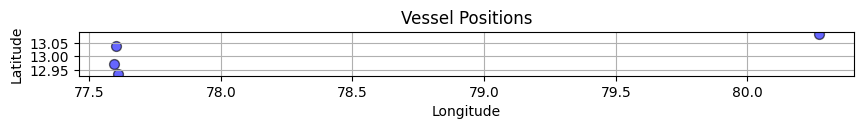

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

# Plot vessel positions
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=50, alpha=0.6, edgecolor='k')
ax.set_title('Vessel Positions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


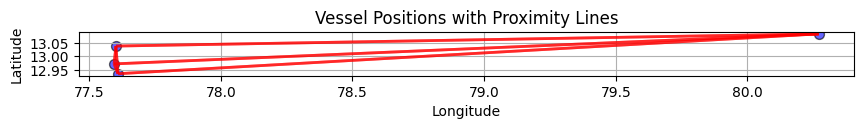

In [34]:
import geopandas as gpd
from shapely.geometry import Point, LineString

def create_proximity_gdf(df, proximity_pairs):
    lines = []
    for i, j in proximity_pairs:
        # Create a LineString representing the proximity pair
        line = LineString([
            (df.loc[i, 'longitude'], df.loc[i, 'latitude']),
            (df.loc[j, 'longitude'], df.loc[j, 'latitude'])
        ])
        lines.append({'geometry': line})

    # Create GeoDataFrame
    lines_gdf = gpd.GeoDataFrame(lines, geometry='geometry', crs="EPSG:4326")
    return lines_gdf

# Create GeoDataFrame for proximity lines
pairs_gdf = create_proximity_gdf(df, proximity_pairs)

# Plot vessel positions and proximity pairs
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=50, alpha=0.6, edgecolor='k')
pairs_gdf.plot(ax=ax, color='red', alpha=0.6, linewidth=2)
ax.set_title('Vessel Positions with Proximity Lines')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


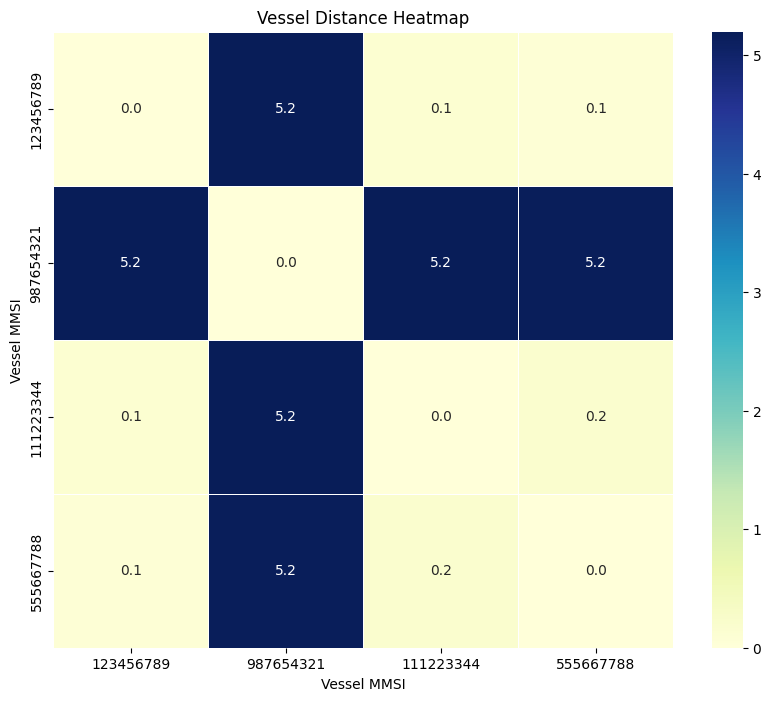

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert distance matrix to DataFrame
distances_df = pd.DataFrame(distances, index=df['mmsi'], columns=df['mmsi'])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distances_df, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5)
plt.title('Vessel Distance Heatmap')
plt.xlabel('Vessel MMSI')
plt.ylabel('Vessel MMSI')
plt.show()


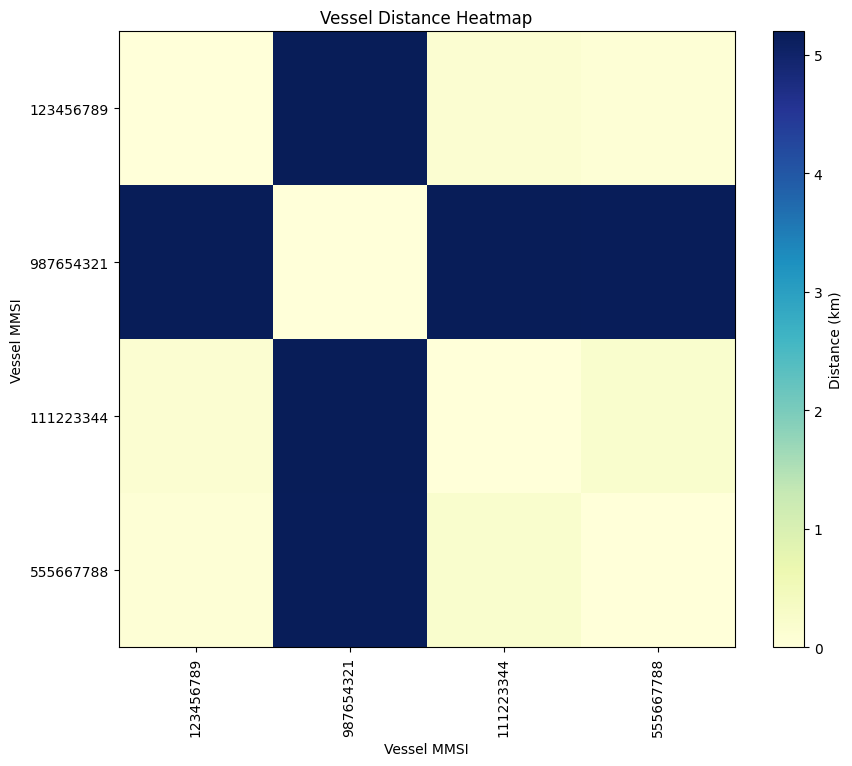

In [37]:
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(distances_df, cmap='YlGnBu', interpolation='nearest')
plt.colorbar(label='Distance (km)')
plt.title('Vessel Distance Heatmap')
plt.xlabel('Vessel MMSI')
plt.ylabel('Vessel MMSI')
plt.xticks(ticks=range(len(distances_df.columns)), labels=distances_df.columns, rotation=90)
plt.yticks(ticks=range(len(distances_df.index)), labels=distances_df.index)
plt.show()


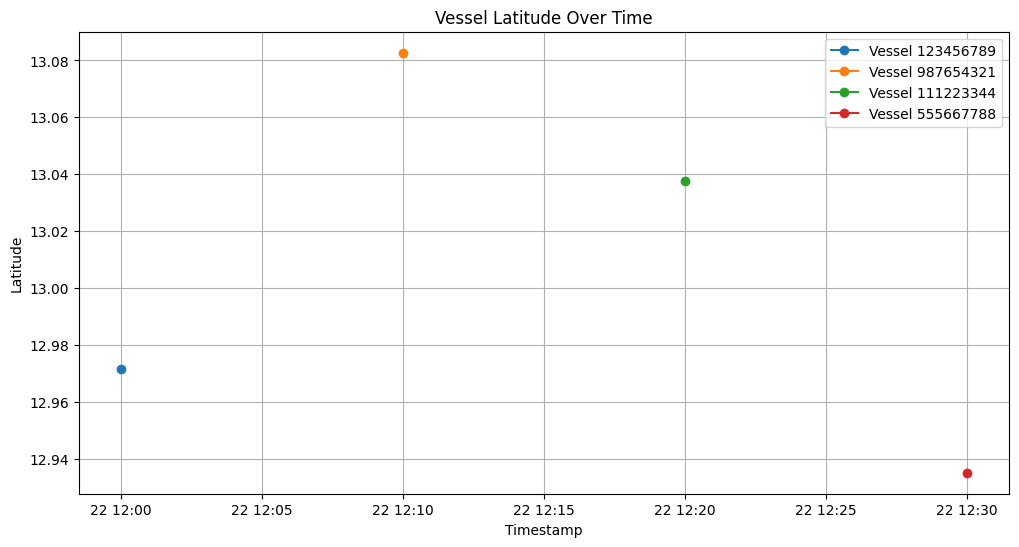

In [38]:
# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plot vessel positions over time
plt.figure(figsize=(12, 6))
for mmsi in df['mmsi'].unique():
    vessel_df = df[df['mmsi'] == mmsi]
    plt.plot(vessel_df['timestamp'], vessel_df['latitude'], marker='o', label=f'Vessel {mmsi}')

plt.xlabel('Timestamp')
plt.ylabel('Latitude')
plt.title('Vessel Latitude Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
import folium

# Sample data
data = {
    'latitude': [12.9716, 13.0827, 13.0376, 12.9352],
    'longitude': [77.5946, 80.2707, 77.6014, 77.6094],
    'mmsi': [123456789, 987654321, 111223344, 555667788],
    'timestamp': ['2024-08-22 12:00:00', '2024-08-22 12:10:00', '2024-08-22 12:20:00', '2024-08-22 12:30:00']
}

import pandas as pd
df = pd.DataFrame(data)

# Create a base map
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)

# Add vessel markers
for idx, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Vessel MMSI: {row['mmsi']}, Timestamp: {row['timestamp']}",
        icon=folium.Icon(color='blue')
    ).add_to(m)

# Save the map as an HTML file
map_path = 'vessel_map.html'
m.save(map_path)

print(f"Map has been saved to {map_path}")


Map has been saved to vessel_map.html


In [42]:
from IPython.display import display

# Display the map directly in Jupyter Notebook
display(m)
